# 03 - Classification

https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/03-classification/homework.md

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
print(df.shape)
df.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

In [4]:
# For the rest of the homework, you'll need to use only these columns:
columns = [ 'latitude',
            'longitude',
            'housing_median_age',
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income',
            'median_house_value',
            'ocean_proximity']

## Data preparation

In [5]:
# Select only the features from above and fill in the missing values with 0.
df[columns] = df[columns].fillna(0)

In [6]:
# Create a new column rooms_per_household by dividing the column total_rooms by the column households from dataframe.
df['rooms_per_household'] = df['total_rooms'] / df['households']

In [7]:
# Create a new column bedrooms_per_room by dividing the column total_bedrooms by the column total_rooms from dataframe.
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']

In [8]:
# Create a new column population_per_household by dividing the column population by the column households from dataframe.
df['population_per_household'] = df['population'] / df['households']

# Question 1

What is the most frequent observation (mode) for the column ocean_proximity?

In [9]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
df['ocean_proximity'].mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object

Answer: <1H OCEAN

## Split the data

* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
* Make sure that the target value (median_house_value) is not in your dataframe.

In [11]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=len(df_test), random_state=42)
df_train.shape, df_val.shape, df_test.shape

((12384, 13), (4128, 13), (4128, 13))

In [12]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

target_column = 'median_house_value'

y_train = df_train.pop(target_column)
y_val = df_val.pop(target_column)
y_test = df_test.pop(target_column)

# Question 2

* Create the correlation matrix for the numerical features of your train dataset.
* In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
* What are the two features that have the biggest correlation in this dataset?

In [13]:
corr_matrix = df_train.select_dtypes(exclude=['object']).corr().unstack().reset_index()
corr_matrix.columns = ['feature_1', 'feature_2', 'corr']
corr_matrix.sort_values(by='corr', ascending=False, inplace=True)
corr_matrix.query('corr < 1').head(1)

,feature_1,feature_2,corr
50,total_bedrooms,households,0.979399


Answer: total_bedrooms and households

### Make median_house_value binary

* We need to turn the median_house_value variable from numeric into binary.
* Let's create a variable above_average which is 1 if the median_house_value is above its mean value and 0 otherwise.

In [14]:
y_train_average = y_train.mean()
y_train_above_average = (y_train >= y_train_average).values.astype(int)
y_val_above_average = (y_val >= y_train_average).values.astype(int)

# Question 3

* Calculate the mutual information score with the (binarized) price for the categorical variable that we have. Use the training set only.
* What is the value of mutual information?
* Round it to 2 decimal digits using round(score, 2)

In [15]:
mi_score = mutual_info_score(df_train.ocean_proximity, y_train_above_average)
mi_score

0.10138385763624205

In [16]:
round(mi_score, 2)

0.1

Answer: 0.1

# Question 4

* Now let's train a logistic regression
* Remember that we have one categorical variable ocean_proximity in the data. Include it using one-hot encoding.
* Fit the model on the training dataset.
* To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
** model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [17]:
def train(model, df_train, y_train):
    
    # one-hot encoding
    dv = DictVectorizer(sparse=False)
    train_dicts = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)
    
    # fit the model
    model.fit(X_train, y_train)
    
    return dv, model    

In [18]:
def evaluate_model(dv, model, fun_score, df, y):
    # predictions
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict(X)
    
    if fun_score == 'accuracy':
        return y_pred, accuracy_score(y, y_pred)
    elif fun_score == 'rmse':
        return y_pred, mean_squared_error(y, y_pred, squared=False)
    else:
        return y_pred   

In [19]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
dv, model = train(model, df_train, y_train_above_average)
_, acc_score = evaluate_model(dv, model, 'accuracy', df_val, y_val_above_average)
acc_score

0.8359980620155039

In [20]:
round(acc_score,2)

0.84

Answer: 0.84

# Question 5

* Let's find the least useful feature using the feature elimination technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
* Which of following feature has the smallest difference?
** total_rooms
** total_bedrooms
** population
** households
* note: the difference doesn't have to be positive

In [21]:
scores = []
for exclude_col in columns:
    if exclude_col == target_column:
        continue
        
    cols = list(set(columns) - set([exclude_col]) - set([target_column]))
    
    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    dv, model = train(model, df_train[cols], y_train_above_average)
    _, score = evaluate_model(dv, model, 'accuracy', df_val[cols], y_val_above_average)
    scores.append([exclude_col, score, abs(acc_score - score)])

In [22]:
pd.DataFrame(scores, columns=['feature', 'accuracy', 'accuracy_delta']).sort_values(by='accuracy_delta').head(1)

,feature,accuracy,accuracy_delta
4,total_bedrooms,0.836483,0.000484


Answer: total_bedrooms

# Question 6

* For this question, we'll see how to use a linear regression model from Scikit-Learn
* We'll need to use the original column 'median_house_value'. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model (model = Ridge(alpha=a, solver="sag", random_state=42)) on the training data.
* This model has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10]
* Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

In [23]:
y_train_log = np.log(y_train)
y_val_log = np.log(y_val)

In [24]:
scores = []
for alpha in  tqdm([0, 0.01, 0.1, 1, 10]):
    model = Ridge(alpha=alpha, solver="sag", random_state=42)
    dv, model = train(model, df_train, y_train_log)
    _, score = evaluate_model(dv, model, 'rmse', df_val, y_val_log)
    print(f'{alpha} \t {score}')
    scores.append([alpha, round(score,3)])

  0%|          | 0/5 [00:00<?, ?it/s]

0 	 0.524067160039661
0.01 	 0.5240671600567748
0.1 	 0.5240671602193535
1 	 0.5240671618537078
10 	 0.5240671781715663


In [25]:
pd.DataFrame(scores, columns=['alpha','rmse'])

,alpha,rmse
0,0.00,0.524
1,0.01,0.524
2,0.10,0.524
3,1.00,0.524
4,10.00,0.524


Anwer: 0

In [26]:
# check model
model = Ridge(alpha=alpha, solver="sag", random_state=42)
dv, model = train(model, df_train, y_train_log)
y_pred, score = evaluate_model(dv, model, 'rmse', df_val, y_val_log)

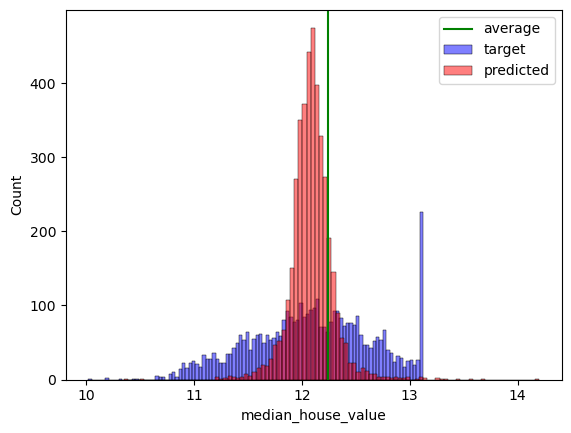

In [28]:
sns.histplot(y_val_log, bins=100, color='b', alpha=0.5, label='target')
sns.histplot(y_pred, bins=100, color='r', alpha=0.5, label='predicted')
plt.axvline(np.log(y_train_average), c='g',label='average')
plt.legend();